In [55]:
import pandas as pd
from database.market import Market
from datetime import datetime,timedelta
from parameters.parameters import Parameters
from backtester.backtester_lite import BacktesterLite
from processor.processor import Processor as p
from tqdm import tqdm
import matplotlib.pyplot as plt

In [56]:
market = Market()

In [57]:
market.connect()
sp500 = market.retrieve("sp500").rename(columns={"Symbol":"ticker"})
market.disconnect()

In [58]:
start_date = datetime(2000,1,1)
end_date = datetime(2020,1,1)
lookbacks = [5]
holding_periods = [1]
floors = [-10,0]
ceilings = [1,10]
local_min = [False]
volatilities = [0.1,0.5,1]
# positions = 20
# tickers = sp500["ticker"]
# asset = "stocks"
positions = 1
tickers = ["BTC"]
asset = "crypto"

In [59]:
parameters = Parameters.parameters_lite(lookbacks,holding_periods,ceilings,floors,volatilities,local_min)

In [60]:
len(parameters)

48

In [61]:
simulation = []
market.connect()
for ticker in tqdm(tickers):
    try:
        ticker_data = market.retrieve_ticker_prices(asset,ticker)
        ticker_data = p.column_date_processing(ticker_data)
        ticker_data.sort_values("date",inplace=True)
        ticker_data["week"] = [x.week for x in ticker_data["date"]]
        ticker_data["day"] = [x.weekday() for x in ticker_data["date"]]
        ticker_data["prev_close"] = ticker_data["adjclose"].shift(1)
        for lookback in lookbacks:
            ticker_data[f"window_{lookback}"] = ticker_data["prev_close"].shift(lookback)
            ticker_data[f"rolling_{lookback}"] = ticker_data["prev_close"].rolling(lookback).mean()
            ticker_data["d1"] = ticker_data[f"adjclose"].pct_change()
#             ticker_data["d2"] = ticker_data["d1"].pct_change()
#             ticker_data["d3"] = ticker_data["d2"].pct_change()
            ticker_data[f"rolling_stdev_{lookback}"] = ticker_data["prev_close"].rolling(lookback).std()
            ticker_data[f"rolling_pct_stdev_{lookback}"] = ticker_data[f"rolling_stdev_{lookback}"] / ticker_data[f"rolling_{lookback}"]
        for holding_period in holding_periods:
            ticker_data[f"return_{holding_period}"] = (ticker_data["adjclose"].shift(-holding_period) - ticker_data["adjclose"]) / ticker_data["adjclose"]
        simulation.append(ticker_data.dropna())
    except Exception as e:
        print(ticker,str(e))
market.disconnect()
final = pd.concat(simulation)

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 489/489 [00:42<00:00, 11.53it/s]


In [62]:
final["d1"].median()

0.000560852495141706

In [63]:
final = pd.concat(simulation)

In [64]:
all_trades = []
for iteration in tqdm(range(len(parameters))):
    try:
        parameter = parameters[iteration]
        trades = BacktesterLite.backtest(positions,final.copy(),iteration,parameter,False)
        all_trades.append(trades)
    except Exception as e:
        print(str(e))

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 48/48 [02:51<00:00,  3.57s/it]


In [65]:
analysis = pd.concat(all_trades)
analysis["return"] = analysis["return"] + 1

In [66]:
report = []
for iteration in tqdm(range(len(parameters))):
    try:
        parameter = parameters[iteration]
        iteration_trades = analysis[analysis["iteration"]==iteration]
        iteration_trades = iteration_trades[(iteration_trades["date"]>=start_date) & (iteration_trades["date"]<=end_date)]
        cumulative = iteration_trades.pivot_table(values="return",index="date",columns="position").reset_index()
        for i in range(positions):
            if float(i) not in cumulative.columns:
                cumulative[float(i)] = 1
        cumulative["pv"] = [sum([row[1][float(x)] * float(1/positions) for x in range(positions)]) for row in cumulative.iterrows()]
        iter_report = cumulative.cumprod().iloc[-1]
        for key in parameter.keys():
            iter_report[key] = parameter[key]
        iter_report["iteration"] = iteration
        report.append(iter_report[["pv","iteration"] + list(parameter.keys())])
    except Exception as e:
        print(str(e))
        continue

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 48/48 [00:23<00:00,  2.07it/s]


In [67]:
iteration_trades

,date,ticker,signal,return,position,iteration,strategy,value,lookback,holding_period,floor,ceiling,volatility,local_min
0,2000-01-11,SJM,-0.006316,1.006316,0,47,window,False,5,1,0,10,1.0,False
1,2000-01-11,BIO,-0.005333,1.010870,1,47,window,False,5,1,0,10,1.0,False
2,2000-01-11,ADM,-0.005025,1.026383,2,47,window,False,5,1,0,10,1.0,False
3,2000-01-11,PWR,-0.004633,1.015012,3,47,window,False,5,1,0,10,1.0,False
4,2000-01-11,TROW,-0.003429,1.042857,4,47,window,False,5,1,0,10,1.0,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
100113,2019-12-31,WST,-0.000199,1.009379,13,47,window,False,5,1,0,10,1.0,False
100114,2019-12-31,AEE,-0.000131,0.990234,14,47,window,False,5,1,0,10,1.0,False
100115,2019-12-31,GLW,-0.000000,1.030230,15,47,window,False,5,1,0,10,1.0,False
100116,2019-12-31,JNPR,-0.000000,1.003248,16,47,window,False,5,1,0,10,1.0,False


In [68]:
performance = pd.DataFrame(report)

In [69]:
performance.sort_values("pv",ascending=False).head(20)

position,pv,iteration,strategy,value,lookback,holding_period,floor,ceiling,volatility,local_min
5024,995.285737,32,window,True,5,1,-10,10,1.0,False
5024,950.641164,31,window,True,5,1,-10,10,0.5,False
5024,869.027692,35,window,True,5,1,0,10,1.0,False
5024,830.046554,34,window,True,5,1,0,10,0.5,False
5024,798.568479,25,window,True,5,1,-10,1,0.5,False
5024,798.568479,26,window,True,5,1,-10,1,1.0,False
5024,697.265214,29,window,True,5,1,0,1,1.0,False
5024,697.265214,28,window,True,5,1,0,1,0.5,False
5024,583.833891,8,rolling,True,5,1,-10,10,1.0,False
5024,560.426009,1,rolling,True,5,1,-10,1,0.5,False


In [70]:
iteration = performance.sort_values("pv",ascending=False).iloc[0]["iteration"]
parameter = parameters[iteration]
iteration_trades = analysis[analysis["iteration"]==iteration]
iteration_trades = iteration_trades[(iteration_trades["date"]>=start_date) & (iteration_trades["date"]<=end_date)]
cumulative = iteration_trades.pivot_table(values="return",index="date",columns="position").reset_index()
cumulative["pv"] = [sum([row[1][float(x)] * float(1/positions) for x in range(positions)]) for row in cumulative.iterrows()]
cumulative["pv"] = cumulative["pv"].cumprod()

In [71]:
cumulative

position,date,0,1,2,3,4,5,6,7,8,...,11,12,13,14,15,16,17,18,19,pv
0,2000-01-11,0.966933,0.974458,0.922333,0.989001,0.947093,1.001755,1.134420,1.026953,1.007522,...,0.933379,0.940054,0.912356,0.942786,0.964659,0.981280,0.952210,0.995714,1.009969,0.976750
1,2000-01-12,1.023666,1.023707,0.955574,1.047987,0.916535,1.000000,1.022260,0.978496,1.050183,...,1.008276,1.034707,0.992534,1.097257,0.961001,0.980897,1.008000,1.037445,1.089670,0.995290
2,2000-01-13,1.046167,1.042045,0.987973,1.013662,1.059878,1.042962,1.014543,0.993684,0.979346,...,0.981132,0.944596,1.023974,1.054444,1.101685,1.038140,0.871795,1.043645,0.985517,1.007094
3,2000-01-14,1.138889,0.931532,1.044970,0.995439,1.043332,1.029292,0.979286,0.995052,1.000000,...,1.152041,0.973519,0.995655,1.040612,1.000000,1.010870,0.989496,0.939839,0.960254,1.017841
4,2000-01-18,1.053918,1.019001,1.015625,0.996066,0.972286,0.981132,0.975914,1.062884,1.041790,...,0.956284,0.970322,0.994443,1.018182,1.002272,0.941967,1.000000,1.304976,0.949913,1.030750
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5020,2019-12-24,0.995042,1.002613,0.998348,1.000069,0.995658,1.002822,0.971071,1.002799,0.996201,...,0.996092,0.996429,0.986441,0.997660,1.002758,1.003779,0.991348,1.011341,1.001913,995.095776
5021,2019-12-26,1.000343,1.001460,1.003380,0.993017,0.998859,0.996584,1.000647,1.003941,0.999632,...,1.004678,0.993124,0.984742,0.987061,0.989825,1.009965,0.991736,1.000262,0.992924,992.666434
5022,2019-12-27,0.983918,0.991540,0.993387,0.991197,0.999616,0.990301,0.998808,1.008792,0.995313,...,1.005609,0.998629,0.996153,0.997897,0.991773,0.988303,1.001539,1.008795,0.989027,988.512593
5023,2019-12-30,0.997060,1.003431,1.001570,1.010459,1.006471,1.002626,1.004391,0.998223,1.009423,...,0.999539,1.013255,1.011702,1.027611,0.991709,1.002585,1.002789,1.004214,1.002745,993.811615


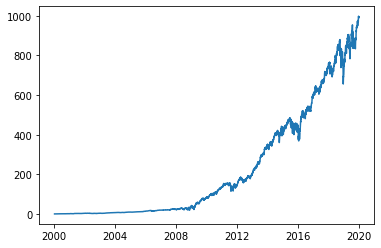

In [72]:
plt.plot(cumulative["date"],cumulative["pv"])

In [73]:
parameter

{'strategy': 'window',
 'value': True,
 'lookback': 5,
 'holding_period': 1,
 'floor': -10,
 'ceiling': 10,
 'volatility': 1,
 'local_min': False}